## Setup

In [1]:
# Load libraries
library(simmer)
library(simmer.plot)
library(tidyverse)
library(tidymodels)

# Set seed for reproducibility
set.seed(42)

Loading required package: ggplot2

Attaching package: ‘simmer.plot’

The following objects are masked from ‘package:simmer’:

    get_mon_arrivals, get_mon_attributes, get_mon_resources

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.5.2
✔ lubridate 1.9.4     ✔ tibble    3.3.0
✔ purrr     1.1.0     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()       masks stats::filter()
✖ dplyr::lag()          masks stats::lag()
✖ lubridate::now()      masks simmer::now()
✖ lubridate::rollback() masks simmer::rollback()
✖ dplyr::select()       masks simmer::select()
✖ tidyr::separate()     masks simmer::separate()
ℹ Use the ]8;;http://conflicted.r-lib.org/conflicted package]8;; to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.4.1 ──
✔ broom        1.0.10  

Warning message:
package ‘parsnip’ was built under R version 4.5.2 


In [6]:
# Load MIMIC-IV data

# Define data directory
# data_dir <- "~/Desktop/MIMIC_ED/processed/"
# data_dir <- "../../../MIMIC_ED/processed/" 
data_dir <- "processed/"

# Load all four tables
ed_stays <- read_csv(paste0(data_dir, "ed_stays.csv"))
ed_activities <- read_csv(paste0(data_dir, "ed_activity_log.csv"))
ed_diagnoses <- read_csv(paste0(data_dir, "ed_diagnoses.csv"))
ed_medications <- read_csv(paste0(data_dir, "ed_medications.csv"))


# query medcount per stay
med_count_per_stay <- ed_medications %>%
  group_by(stay_id) %>%
  summarise(medication_count = n()) 

Rows: 425028 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (5): gender, race, arrival_transport, disposition, chiefcomplaint
dbl  (5): stay_id, subject_id, hadm_id, acuity, ed_los_hours
lgl  (1): is_admitted
dttm (3): arrival_time, triage_time, depart_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 3737756 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): activity
dbl  (5): stay_id, subject_id, hadm_id, acuity, activity_seq
dttm (1): timestamps

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 898730 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): icd_code, icd_t


Data quality check:
Records where disposition says ADMITTED but flag is FALSE: 0 

Dataset overview:
Total ED visits: 425,028 
Admitted patients: 158,010 ( 37.2 %)

ED LOS for admitted patients:
In minutes:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0   260.0   374.0   436.6   527.0 29584.2 

In hours:
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
  0.01667   4.33333   6.23333   7.27716   8.78333 493.06944 

80th percentile LOS: 573 minutes (about 9.55 hours)
Patients above this threshold would transfer to Hospital 2 in Phase 2


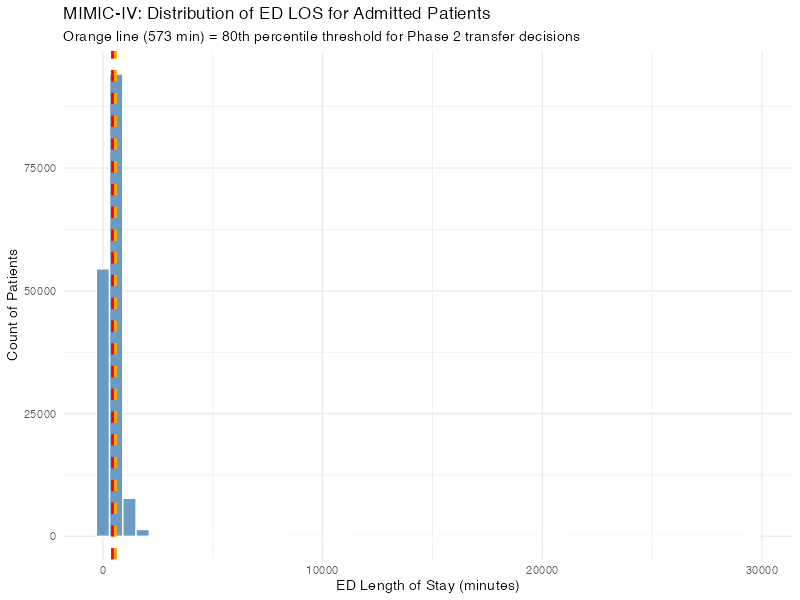

In [86]:
# Clean up the data for simulation

# Get just the admitted patients (Kayanne's Predictor model uses this)
ed_admitted <- ed_stays %>%
  filter(is_admitted == TRUE) %>%
  mutate(
    los_minutes = ed_los_hours * 60,
    # If LOS is missing or weird, use the median instead
    los_minutes = if_else(is.na(los_minutes) | los_minutes <= 0, 
                          median(los_minutes, na.rm = TRUE), 
                          los_minutes)
  )

# Quick check - make sure the data makes sense
inconsistencies <- ed_stays %>%
  filter(disposition == "ADMITTED" & is_admitted == FALSE) %>%
  nrow()

cat("\nData quality check:\n")
cat("Records where disposition says ADMITTED but flag is FALSE:", inconsistencies, "\n")

# Look at overall numbers
total_visits <- nrow(ed_stays)
total_admitted <- nrow(ed_admitted)
admission_rate <- round(100 * total_admitted / total_visits, 1)

cat("\nDataset overview:\n")
cat("Total ED visits:", format(total_visits, big.mark = ","), "\n")
cat("Admitted patients:", format(total_admitted, big.mark = ","), 
    "(", admission_rate, "%)\n")

# Check the LOS distribution for admitted patients
cat("\nED LOS for admitted patients:\n")
cat("In minutes:\n")
print(summary(ed_admitted$los_minutes))
cat("\nIn hours:\n")
print(summary(ed_admitted$ed_los_hours))

# Figure out the 80th percentile - this is the threshold for Phase 2 transfer logic
los_threshold_80 <- quantile(ed_admitted$los_minutes, 0.80, na.rm = TRUE)

cat("\n80th percentile LOS:", round(los_threshold_80, 2), "minutes")
cat(" (about", round(los_threshold_80/60, 2), "hours)\n")
cat("Patients above this threshold would transfer to Hospital 2 in Phase 2\n")

# Visualize LOS distribution for admitted patients (for Phase 2 transfer logic)
ggplot(ed_admitted, aes(x = los_minutes)) +
  geom_histogram(bins = 50, fill = "steelblue", color = "white", alpha = 0.8) +
  geom_vline(aes(xintercept = mean(los_minutes, na.rm = TRUE)), 
             color = "red", linetype = "dashed", linewidth = 1) +
  geom_vline(aes(xintercept = los_threshold_80), 
             color = "orange", linetype = "dashed", linewidth = 1) +
  labs(
    title = "MIMIC-IV: Distribution of ED LOS for Admitted Patients",
    subtitle = "Orange line (573 min) = 80th percentile threshold for Phase 2 transfer decisions",
    x = "ED Length of Stay (minutes)",
    y = "Count of Patients"
  ) +
  theme_minimal()

## Parameters

In [9]:
# function that simplifies race into 6 main categories (the model uses it so it needs to be defined here)
simplify_race <- function(r) {
  r <- toupper(as.character(r))
  
  if (grepl("WHITE", r)) {
    "WHITE"
  } else if (grepl("BLACK", r) || grepl("AFRICAN", r)) {
    "BLACK"
  } else if (grepl("HISPANIC", r) || grepl("LATINO", r)) {
    "HISPANIC"
  } else if (grepl("ASIAN", r)) {
    "ASIAN"
  } else if (grepl("NATIVE", r) || grepl("PACIFIC", r) || grepl("ALASKA", r)) {
    "NATIVE/PI"
  } else {
    "OTHER"
  }
}

simplify_race_vec <- function(r) {
  sapply(r, simplify_race)
}

# log_hosp_los_hours ~ acuity + race + gender + ed_los_hours + medication_count
# mod <- readRDS("../models/model_v1.rds")
mod <- readRDS("models/model_v1.rds")


In [87]:
# Calculate inter-arrival rate from aggregate data

# Note: Individual patient timestamps are shifted for privacy, so we cannot 
# directly calculate time between consecutive arrivals. Instead, we use the 
# total time span and patient count to derive the average arrival rate.

# MIMIC-IV ED data spans 9 years (2011–2019)
years_span <- 2019 - 2011 + 1  # 9 years
actual_time_span <- years_span * 365 * 24 * 60  # ~4,730,400 minutes
# (Approximate, ignores leap years)

# Total ED visits in dataset
total_visits <- nrow(ed_stays)  # 425,028

# Calculate mean time between arrivals
mean_inter_arrival <- actual_time_span / total_visits  # minutes per patient

cat("Mean inter-arrival:", mean_inter_arrival, "minutes\n")
cat("Or about", 60 / mean_inter_arrival, "patients per hour\n")
cat("This equals approximately", round(24 * 60 / mean_inter_arrival), "patients per day\n")

# Validation: Beth Israel Deaconess reports 110–164 ED visits/day.
# Our calculated rate (~129 visits/day) now falls within this range,
# suggesting the dataset is reasonably complete (though some missingness is still possible).


Mean inter-arrival: 11.12962 minutes
Or about 5.39102 patients per hour
This equals approximately 129 patients per day


In [89]:
# Resource capacities (start with infinite as Karandeep suggested)
ED_BED_CAPACITY <- Inf

# Time distributions using MIMIC-IV data
# All ED patients (Simulator)
los_time <- function() {
  los_hours <- sample(ed_stays$ed_los_hours, 1)
  if (is.na(los_hours) || los_hours <= 0) {
    los_hours <- median(ed_stays$ed_los_hours, na.rm = TRUE)
  }
  los_hours * 60  # return LOS in minutes
}

# Arrival rate, using mean_inter_arrival computed above
# Mean inter-arrival: ~11.1 minutes (~129 patients/day)
mean_inter_arrival <- mean_inter_arrival
arrival_interval <- function() {
  rexp(1, rate = 1 / mean_inter_arrival)
}

# Store the transfer threshold for Phase 2
LOS_TRANSFER_THRESHOLD <- los_threshold_80

cat("   - LOS: Sampling from", format(nrow(ed_admitted), big.mark = ","), 
    "admitted patient records\n")
cat("   - Mean LOS:", round(mean(ed_admitted$los_minutes), 1), "minutes",
    "(", round(mean(ed_admitted$los_minutes) / 60, 2), "hours)\n")
cat("   - Transfer threshold:", round(LOS_TRANSFER_THRESHOLD, 1), "minutes",
    "(", round(LOS_TRANSFER_THRESHOLD / 60, 2), "hours)\n")


   - LOS: Sampling from 158,010 admitted patient records
   - Mean LOS: 436.6 minutes ( 7.28 hours)
   - Transfer threshold: 573 minutes ( 9.55 hours)


## Patient Trajectory

In [90]:
# PATIENT TRAJECTORY: ED Simulation (Nadine)

patient_trajectory <- trajectory("ED patient flow") %>%
  
  # Patient arrives and occupies ED bed
  seize("ed_bed", 1) %>%
  
  # Patient stays for ED length of stay (sampled from real data)
  # Note: Samples from ALL ED visits (425,028), not just admitted patients
  timeout(los_time) %>%
  
  # Patient leaves ED (either discharged home or admitted to hospital)
  release("ed_bed", 1) %>%
  
  
  # HOSPITAL LOS PREDICTION: For Phase 2 Transfer Logic (Kayanne)
  # This prediction does NOT affect current ED simulation
  # It logs predicted hospital LOS for future transfer decision analysis
  
  log_(function() {
    patient_counter <<- patient_counter + 1
    
    # Sample patient characteristics for prediction
    new_patient <- tibble(
      acuity = sample(ed_stays$acuity, 1),
      race = sample(ed_stays$race, 1),
      gender = sample(ed_stays$gender, 1),
      ed_los_hours = sample(ed_stays$ed_los_hours, 1),
      medication_count = sample(med_count_per_stay$medication_count, 1)
    )
    
    # Predict hospital LOS using Kayanne's XGBoost model
    pred_hours <- predict(mod, new_data = new_patient)$.pred %>% expm1()
    
    # Store prediction for Phase 2 analysis
    hospital_los_log <<- bind_rows(
      hospital_los_log,
      tibble(patient_id = patient_counter, pred_hosp_los = pred_hours)
    )
    
    paste("predicted hospital LOS (hours):", round(pred_hours, 1))
  })

## Build Sim Environment

In [100]:
# Create environment
ed_sim <- simmer("ED Simulation V1")

# Add resources
ed_sim %>%
  add_resource("ed_bed", capacity = ED_BED_CAPACITY)

# Add patient generator
ed_sim %>%
  add_generator("patient", patient_trajectory, arrival_interval, mon = 2)

simmer environment: ED Simulation V1 | now: 0 | next: 0
{ Monitor: in memory }
{ Resource: ed_bed | monitored: TRUE | server status: 0(Inf) | queue status: 0(Inf) }
{ Source: patient | monitored: 2 | n_generated: 0 }

## Run Sim

In [102]:
# Create an empty tibble to store results for predicted LOS
hospital_los_log <- tibble(patient_id = integer(), pred_hosp_los = numeric())

# Counter for patient IDs
patient_counter <- 0

# Run for 2 weeks
ed_sim %>% run(until = 14 * 24 * 60)

# Check final time
simmer::now(ed_sim)

9276.42: patient842: predicted hospital LOS (hours): 53.4
9302.65: patient872: predicted hospital LOS (hours): 67.3
9311.12: patient836: predicted hospital LOS (hours): 72.6
9329.91: patient884: predicted hospital LOS (hours): 94.9
9353.15: patient866: predicted hospital LOS (hours): 31.6
9362.66: patient863: predicted hospital LOS (hours): 64
9368.01: patient888: predicted hospital LOS (hours): 85.1
9383.59: patient885: predicted hospital LOS (hours): 53.7
9383.67: patient869: predicted hospital LOS (hours): 62.6
9405.22: patient837: predicted hospital LOS (hours): 32.7
9412.28: patient861: predicted hospital LOS (hours): 50.4
9430.08: patient879: predicted hospital LOS (hours): 28.5
9431.47: patient875: predicted hospital LOS (hours): 34.7
9434.92: patient880: predicted hospital LOS (hours): 22
9465.28: patient870: predicted hospital LOS (hours): 68.1
9471.89: patient892: predicted hospital LOS (hours): 53.4
9496.34: patient867: predicted hospital LOS (hours): 78.4
9512.86: patient88

[1] 20160

## Extract Results

In [103]:
# Get monitoring data
arrivals <- get_mon_arrivals(ed_sim)
resources <- get_mon_resources(ed_sim)

# Quick summary
summary(arrivals$activity_time)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    8.0   214.0   323.0   422.1   482.0  3649.0 

In [104]:
# predicted hosp LOS
head(hospital_los_log)

# A tibble: 6 × 2
  patient_id pred_hosp_los
       <dbl>         <dbl>
1          1          53.4
2          2          67.3
3          3          72.6
4          4          94.9
5          5          31.6
6          6          64.0

## Visualizations

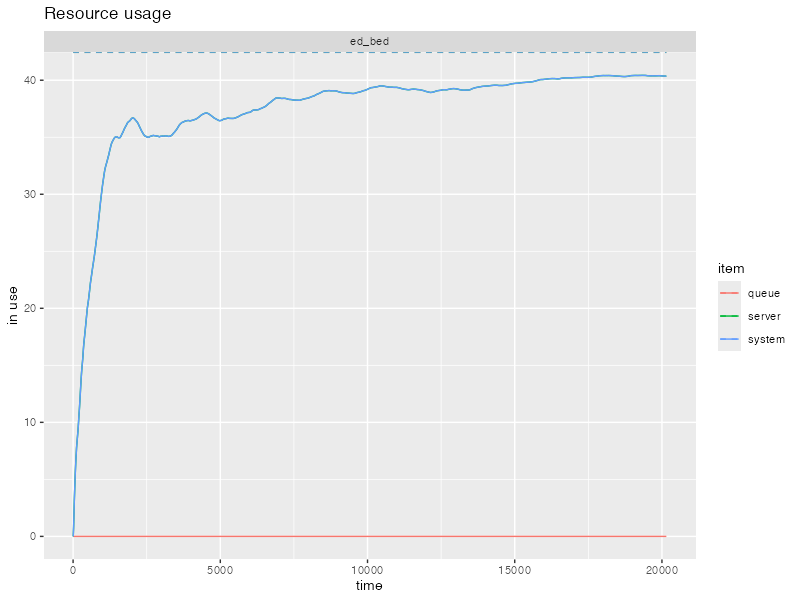

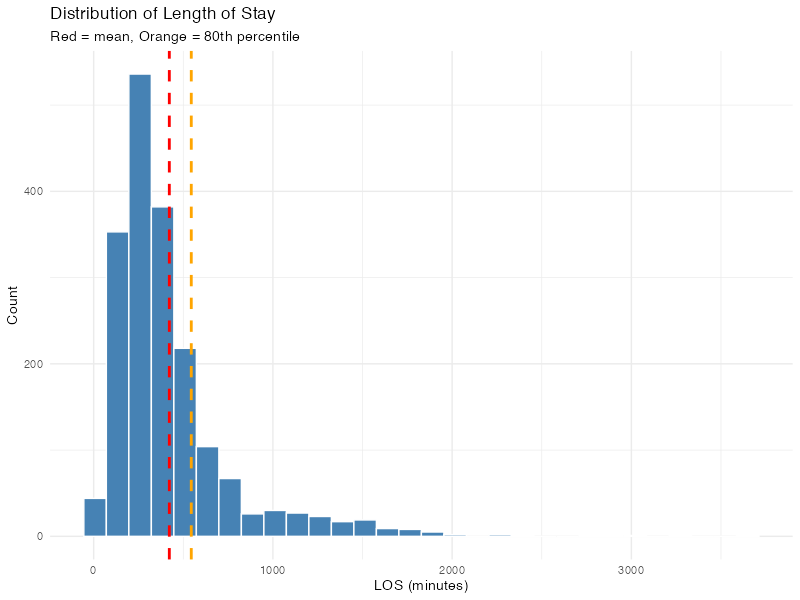

In [105]:
# Plot resource usage over time
plot(resources, metric = "usage")

# Histogram of length of stay
ggplot(arrivals, aes(x = activity_time)) +
  geom_histogram(bins = 30, fill = "steelblue", color = "white") +
  geom_vline(aes(xintercept = mean(activity_time)), 
             color = "red", linetype = "dashed", size = 1) +
  geom_vline(aes(xintercept = quantile(activity_time, 0.80)), 
             color = "orange", linetype = "dashed", size = 1) +
  labs(
    title = "Distribution of Length of Stay",
    subtitle = "Red = mean, Orange = 80th percentile",
    x = "LOS (minutes)",
    y = "Count"
  ) +
  theme_minimal()

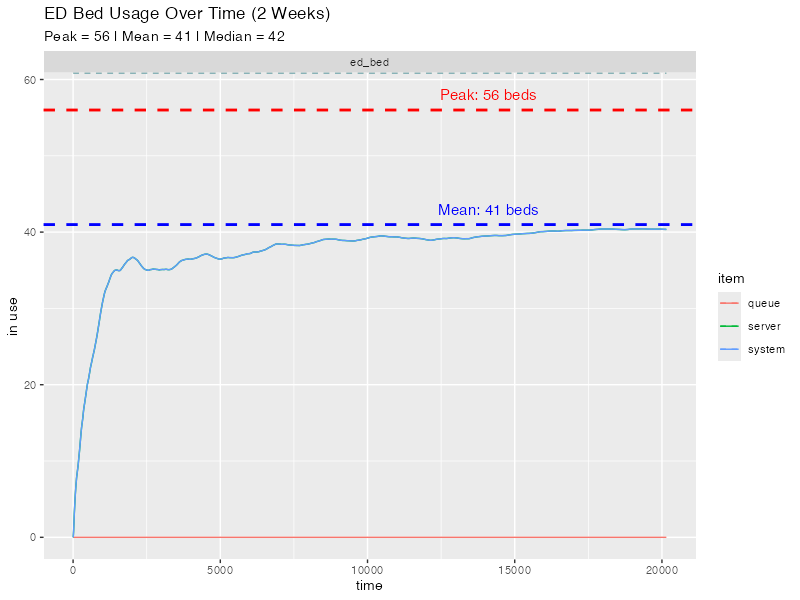

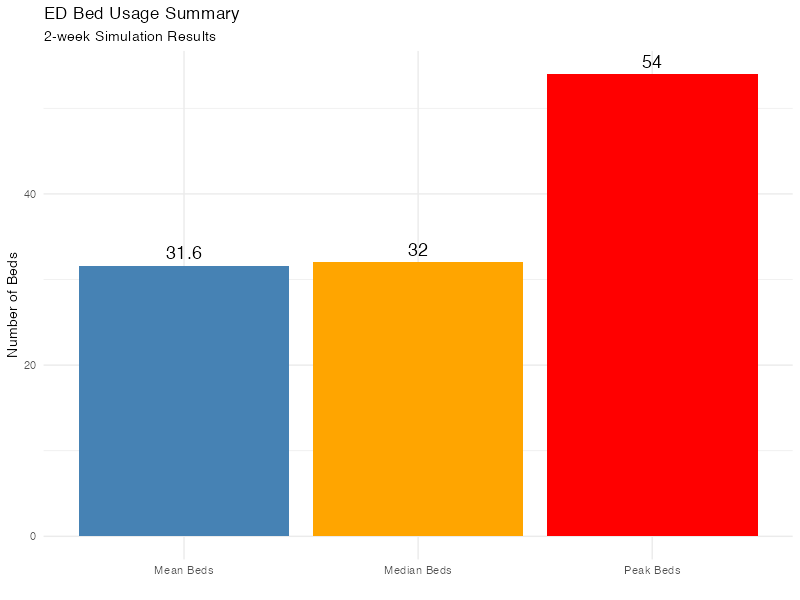

In [116]:
# Calculate key metrics
peak_beds <- max(resources$server[resources$resource == "ed_bed"])
mean_beds <- mean(resources$server[resources$resource == "ed_bed"])
median_beds <- median(resources$server[resources$resource == "ed_bed"])

# Resource usage plot with annotations
plot(resources, metric = "usage") +
  geom_hline(yintercept = peak_beds, color = "red", linetype = "dashed", size = 1) +
  geom_hline(yintercept = mean_beds, color = "blue", linetype = "dashed", size = 1) +
  annotate("text", x = max(resources$time) * 0.7, y = peak_beds + 2, 
           label = paste("Peak:", peak_beds, "beds"), color = "red", size = 4) +
  annotate("text", x = max(resources$time) * 0.7, y = mean_beds + 2, 
           label = paste("Mean:", round(mean_beds, 1), "beds"), color = "blue", size = 4) +
  labs(title = "ED Bed Usage Over Time (2 Weeks)",
       subtitle = paste0("Peak = ", peak_beds, " | Mean = ", round(mean_beds, 1), 
                        " | Median = ", round(median_beds, 1)))

# Bar chart
ggplot(bed_summary, aes(x = Metric, y = Value, fill = Metric)) +
  geom_col() +
  geom_text(aes(label = Value), vjust = -0.5, size = 5) +
  labs(title = "ED Bed Usage Summary",
       subtitle = "2-week Simulation Results",
       y = "Number of Beds",
       x = "") +
  theme_minimal() +
  theme(legend.position = "none") +
  scale_fill_manual(values = c("Peak Beds" = "red", 
                                "Mean Beds" = "steelblue", 
                                "Median Beds" = "orange"))

In [110]:
cat("\nED Bed Capacity Analysis\n")
cat("Ran simulation for 2 weeks\n")
cat("Total patients in simulation:", nrow(arrivals), "\n\n")

cat("Results:\n")
cat("  Peak beds needed:", peak_beds, "\n")
cat("  Average beds in use:", round(mean_beds, 1), "\n")
cat("  Median beds in use:", round(median_beds, 1), "\n\n")

cat("Takeaway:\n")
cat("  Based on the simulation, Beth Israel ED needs around", peak_beds, "beds\n")
cat("  to handle typical patient volume (~129 patients/day).\n")
cat("  Adding a 10% safety buffer would be", ceiling(peak_beds * 1.1), "beds.\n\n")

cat("Notes:\n")
cat("  - Used infinite capacity to estimate true underlying demand\n")
cat("  - Sampled ED LOS from all 425,028 patients in MIMIC-IV\n")
cat("  - Arrival rate: ~11.1 min between patients (~129 patients/day), based on 2011–2019 span\n")


ED Bed Capacity Analysis
Ran simulation for 2 weeks
Total patients in simulation: 1878 

Results:
  Peak beds needed: 56 
  Average beds in use: 41 
  Median beds in use: 42 

Takeaway:
  Based on the simulation, Beth Israel ED needs around 56 beds
  to handle typical patient volume (~129 patients/day).
  Adding a 10% safety buffer would be 62 beds.

Notes:
  - Used infinite capacity to estimate true underlying demand
  - Sampled ED LOS from all 425,028 patients in MIMIC-IV
  - Arrival rate: ~11.1 min between patients (~129 patients/day), based on 2011–2019 span


## Validation Run: 62 Bed Capacity

Based on the baseline run, we set capacity to 62 beds (peak + 10% buffer) to validate adequacy and observe utilization.

In [112]:
ED_BED_CAPACITY <- 62

# Rebuild simulation with constrained capacity
ed_sim_constrained <- simmer("ED Simulation - 60 Bed Capacity") %>%
  add_resource("ed_bed", capacity = ED_BED_CAPACITY) %>%
  add_generator("patient", patient_trajectory, arrival_interval, mon = 2) %>%
  run(until = 14 * 24 * 60)

290.361: patient1: predicted hospital LOS (hours): 59.7
313.377: patient5: predicted hospital LOS (hours): 57.3
329.476: patient8: predicted hospital LOS (hours): 70.8
388.145: patient10: predicted hospital LOS (hours): 68.8
404.24: patient11: predicted hospital LOS (hours): 82.5
427.87: patient4: predicted hospital LOS (hours): 36.4
456.049: patient16: predicted hospital LOS (hours): 72.9
513.311: patient18: predicted hospital LOS (hours): 67.5
539.065: patient20: predicted hospital LOS (hours): 73.4
544.138: patient0: predicted hospital LOS (hours): 72.5
547.387: patient13: predicted hospital LOS (hours): 43
549.717: patient6: predicted hospital LOS (hours): 74.5
554.225: patient28: predicted hospital LOS (hours): 65.3
592.151: patient34: predicted hospital LOS (hours): 87.3
598.492: patient14: predicted hospital LOS (hours): 222.2
603.451: patient31: predicted hospital LOS (hours): 55.1
625.381: patient15: predicted hospital LOS (hours): 82.2
635.635: patient42: predicted hospital L

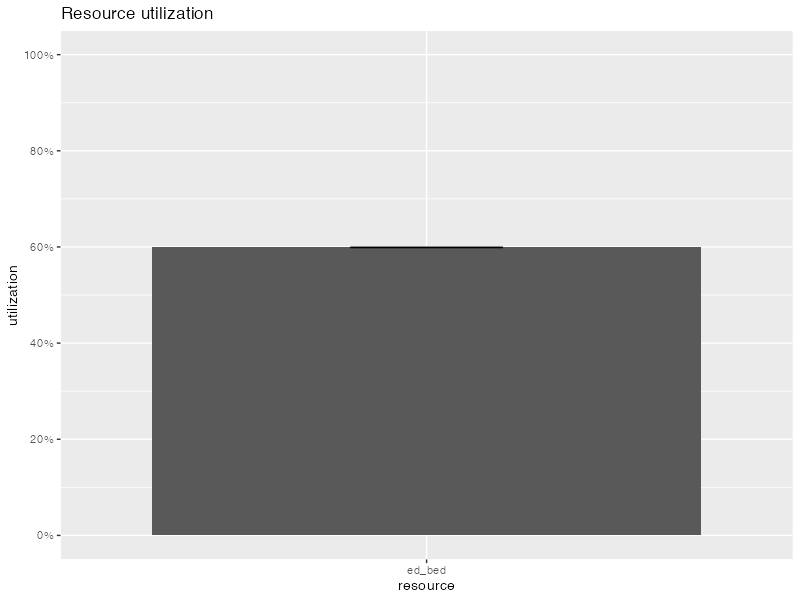

In [ ]:
# Results of 62 bed capacity
arrivals_constrained <- get_mon_arrivals(ed_sim_constrained)
resources_constrained <- get_mon_resources(ed_sim_constrained)
plot(resources_constrained, metric = "utilization")

In [115]:
# Calculate utilization metrics
peak_utilization <- peak_beds / ED_BED_CAPACITY
mean_utilization <- mean_beds / ED_BED_CAPACITY

cat("\nUtilization Analysis\n")
cat("Capacity:", ED_BED_CAPACITY, "beds\n")
cat("Peak utilization:", round(peak_utilization * 100, 1), "%\n")
cat("Mean utilization:", round(mean_utilization * 100, 1), "%\n\n")

cat("Interpretation:\n")
cat("  -", ED_BED_CAPACITY, "beds handle peak demand (", peak_beds, ") without queuing\n", sep = " ")
cat("  - ~", round(mean_utilization * 100, 1), "% average utilization provides buffer for surges\n", sep = "")
cat("  - System is not clearly over- or under-capacity for this demand level\n")


Utilization Analysis
Capacity: 62 beds
Peak utilization: 90.3 %
Mean utilization: 66.1 %

Interpretation:
  - 62 beds handle peak demand ( 56 ) without queuing
  - ~66.1% average utilization provides buffer for surges
  - System is not clearly over- or under-capacity for this demand level
